In [1]:
from pyspark.sql import SparkSession
import os
import boto3
from botocore.client import Config
import cv2 as cv
import numpy as np
from pyspark.sql import functions as f
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import io
from IPython.display import display, clear_output,Image
import time
import mlflow

# 1. Create spark session

In [2]:
spark = SparkSession.builder \
        .master("local") \
        .appName("FaceDetection") \
        .getOrCreate()

In [3]:
# make the large dataframe show pretty
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## 1.1 Check the created cluster

In [4]:
! kubectl get pods

NAME                                                   READY   STATUS      RESTARTS   AGE
deleting-pods-with-completed-status-1623747600-dg6hm   0/1     Completed   0          22m
jupyter-1623740262-5dd68f879f-ql5g8                    1/1     Running     0          144m
mlflow-1623482147-5c6f74ccb7-k4499                     1/1     Running     0          3d2h
mlflow-db-0                                            1/1     Running     0          3d2h
mlflow-deployment-dd54d6c6b-xnglp                      1/1     Running     0          56d
mlflow-model-deployment-869dd96bbf-f7mgs               1/1     Running     0          25d
postgres-1616502799-67f86f5bdf-wfgjx                   1/1     Running     0          83d
ubuntu-1616490233-56d6684bb4-trwqt                     1/1     Running     2          84d


# 2. Set up variables and dependent functions

# 2.1 Variables

In [5]:
bucket_name="pengfei"
image_input_folder_path = "s3a://{}/tmp/sparkcv/input".format(bucket_name)
final_output_bucket_path = "tmp/sparkcv/output/final"
endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
AWS_ACCESS_KEY_ID=os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY=os.getenv("AWS_SECRET_ACCESS_KEY")
SESSION_TOKEN=os.environ['AWS_SESSION_TOKEN']

In [6]:
# get model from mlflow
def get_model_from_mlflow_registry(model_name,stage):
    os.environ["MLFLOW_TRACKING_URI"] = 'https://pengfei-mlflow-8643532378943981908-mlflow-ihm.kub.sspcloud.fr'
    os.environ["MLFLOW_S3_ENDPOINT_URL"] = endpoint
    return mlflow.keras.load_model(model_uri=f"models:/{model_name}/{stage}")

## 2.2 helper functions

In [7]:
# deseriallize byte to opencv image format
def convert_byte_to_nparr(img_byte):
    np_array = cv.imdecode(np.asarray(bytearray(img_byte)), cv.IMREAD_COLOR)
    return np_array

# serialize opencv image format to byte
def convert_nparr_to_byte(img_np_array):
    success, img = cv.imencode('.png', img_np_array)
    return img.tobytes()

# save image byte to s3
def write_img_byte_to_s3(s3_client, img_byte, bucket_name, img_path):
    # set the path of where you want to put the object
    img_object = s3_client.Object(bucket_name, img_path)
    # set the content which you want to write
    img_object.put(Body=img_byte)

# column function for extract image name
def extract_file_name(path):
    return f.substring_index(path, "/", -1)

# render image byte in jupyter
def render_image(image_bytes_list):
    for image_bytes in image_bytes_list:
        image=Image.open(io.BytesIO(image_bytes))
        display(image)

### Helper functions for step 2 (Extract multiple faces from the origin image) 

In [8]:
def face_extraction(image_name, raw_img_content):
    haar_model_name = "haarcascade_frontalface_default.xml"
    haar_model_path = "{}{}".format("/opt/conda/lib/python3.7/site-packages/cv2/data/",haar_model_name)
    img = cv.imdecode(np.asarray(bytearray(raw_img_content)), cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.IMREAD_GRAYSCALE)
    face_model = cv.CascadeClassifier(haar_model_path)
    faces = face_model.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4)  # returns a list of (x,y,w,h) tuples

    # Extract faces from the origin image
    extracted_face_list = []
    for i in range(len(faces)):
        (x, y, w, h) = faces[i]
        img_content = img[y:y + h, x:x + w]
        img_content = cv.resize(img_content, (128, 128))
        extracted_face_img_name = image_name[:-4] + "_x" + str(x) + "_y" + str(y) + "_w" + str(
            w) + "_h" + str(h) + ".png"
        img_byte = convert_nparr_to_byte(img_content)

        extracted_face_list.append((extracted_face_img_name, img_byte))
    return extracted_face_list


face_extraction_schema = ArrayType(StructType([
    StructField("img_name", StringType(), False),
    StructField("img_content", BinaryType(), False)
]))

Face_Extraction_UDF = f.udf(lambda image_name, raw_image_content: face_extraction(image_name, raw_image_content),
                            face_extraction_schema)


### Helper functions for step 3 (Predict if the extracted face wear a mask or not) 

In [9]:
def face_mask_prediction(np_img_str):
    vgg19_model_path = "/home/jovyan/work"
    vgg19_model_name = "masknet.h5"
    # read raw face image
    np_arr_img = convert_byte_to_nparr(np_img_str)
    img = np.reshape(np_arr_img, [1, 128, 128, 3])
    img = img / 255.0
    # fetch local model
    # vgg19_model = tf.keras.models.load_model("{}/{}".format(vgg19_model_path, vgg19_model_name))
    
    # fetch model from mlflow
    vgg19_model=get_model_from_mlflow_registry("face-mask-detection","Production")
    
    # use model to predict image
    score = vgg19_model.predict(img)
    if np.argmax(score) == 0:
        res = True
    else:
        res = False
    # print(res)
    return res


Face_Mask_Prediction_UDF = f.udf(lambda face_image_content: face_mask_prediction(face_image_content), BooleanType())

### Helper functions for step 4(Integrate the prediction result to the original image)

In [10]:
# 
def get_face_coordinate_of_origin_image(face_image_name):
    x = face_image_name.split("_")[1][1:]
    y = face_image_name.split("_")[2][1:]
    w = face_image_name.split("_")[3][1:]
    h = face_image_name.split("_")[4][1:].split('.')[0]
    return int(x), int(y), int(w), int(h)


def integrate_face_mask_prediction(origin_image_name, face_list, origin_image_content):
    final_output_path = "/tmp/sparkcv/output/final/{}".format(origin_image_name)
    buffer_img = cv.imdecode(np.asarray(bytearray(origin_image_content)), cv.IMREAD_COLOR)
    for face in face_list:
        face_image_name = face[0]
        has_mask = face[1]
        # set Label text
        if has_mask:
            mask_label = "MASK"
        else:
            mask_label = "NO MASK"
        # Get the coordinate and size of face image
        (x, y, w, h) = get_face_coordinate_of_origin_image(face_image_name)
        # Set text color for mask label
        mask_label_color = {"MASK": (0, 255, 0), "NO MASK": (0, 0, 255)}

        # Insert mask label to image
        buffer_img = cv.putText(buffer_img, mask_label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5,
                                mask_label_color[mask_label], 2)
        # Insert a rectangle around the face
        buffer_img = cv.rectangle(buffer_img, (x, y), (x + w, y + h), mask_label_color[mask_label], 1)
    # serialize cv image to bytes
    img_bytes=convert_nparr_to_byte(buffer_img)
    # Save the image to s3
    s3_client = boto3.resource('s3',endpoint_url=endpoint,aws_access_key_id=AWS_ACCESS_KEY_ID,
                               aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                               aws_session_token=SESSION_TOKEN,
                               config=Config(signature_version='s3v4'),
                               region_name='us-east-1')
    output_bucket_key="{}/{}".format(final_output_bucket_path,origin_image_name)
    write_img_byte_to_s3(s3_client, img_bytes, bucket_name, output_bucket_key)
    return img_bytes


Integrate_Face_Mask_Prediction_UDF = f.udf(
    lambda origin_img_name, face_list, origin_img_content: integrate_face_mask_prediction(origin_img_name, face_list,origin_img_content),BinaryType())

# Main data pipeline for treating image
To check if everyone wears a face mask or not in an image, we will follow the below steps:
1. Read raw image from s3
2. Detect faces from the raw image, output extracted faces as single images(opencv:haar-cascade)
3. Use a pre-trained vgg19 model to check if a mask is worn
4. Integrate prediction as tags on origin image

## Step 1: Get raw image from s3

In [11]:
image_schema = spark.read.format("binaryFile").load(image_input_folder_path).schema
raw_image_df_stream = spark.readStream \
        .format("binaryFile") \
        .schema(image_schema) \
        .option("maxFilesPerTrigger", "500") \
        .option("recursiveFileLookup", "true") \
        .option("pathGlobFilter", "*.png") \
        .load(image_input_folder_path) \
        .withColumn("time_stamp", f.current_timestamp()) \


### 1.1 Clean the data frame

In [12]:
image_name_df = raw_image_df_stream \
        .select("path", "content","time_stamp") \
        .withColumn("origin_image_name", extract_file_name(f.col("path"))).drop("path")

## Step 2: Extract faces

In [13]:
# use udf Face_Extraction_UDF to extract faces
detected_face_list_df = image_name_df.withColumn("detected_face_list",Face_Extraction_UDF("origin_image_name", "content"))

In [14]:
# Flat the list column to multi rows
detected_face_ob_df = detected_face_list_df.withColumn("extracted_face",f.explode(f.col("detected_face_list"))).drop("detected_face_list")


In [15]:
# flat the struct column to primitive column
detected_face_df = detected_face_ob_df.select(f.col("origin_image_name"),f.col("time_stamp"), f.col("content"),
                                                  f.col("extracted_face.img_name").alias("extracted_face_image_name"),
                                                  f.col("extracted_face.img_content").alias(
                                                      "extracted_face_image_content"))


## Step3 : Predict if the extracted faces wear masks or not

In [16]:
predicted_mask_df = detected_face_df.withColumn("with_mask",Face_Mask_Prediction_UDF("extracted_face_image_content")).drop("extracted_face_image_content").drop("content")



## Step 4: Integrate the prediction result to the original image

In [16]:
# map the face name with the mask prediction result and group them by their origin 
grouped_face_df = predicted_mask_df \
                  .withWatermark("time_stamp", "10 minutes") \
                  .groupBy( \
                          f.window("time_stamp", "10 minutes", "5 minutes"),"origin_image_name") \
                  .agg(f.collect_list(f.struct( \
                *[f.col("extracted_face_image_name").alias("face_name"), f.col("with_mask").alias("with_mask")]))
                  .alias("face_list")) 



In [ ]:
# do a join to load the origin image content to the dataframe
join_with_content_df = grouped_face_df.join(image_name_df,"origin_image_name", "inner")


In [23]:
# integrate prediction and write to s3
final_df = join_with_content_df.withColumn("marked_img_content",Integrate_Face_Mask_Prediction_UDF("origin_image_name", "face_list","content")).drop("content") 


In [16]:
# after agg with window,a new col window is created, writeStream in append mode no longer need .withWatermark("time_stamp", "10 minutes")
stream = grouped_face_df \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("final_df_stream") \
    .start()

NameError: name 'grouped_face_df' is not defined

In [17]:
stream = predicted_mask_df.withWatermark("time_stamp", "10 minutes") \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("final_df_stream") \
    .start()

In [18]:
for x in range(5):
    clear_output(wait=True)
    display(stream.status)
    _df=spark.sql('SELECT * FROM final_df_stream')
    if _df.count()>0:
        display(_df.show(10,False))
        #img_list=_df.select(col_name).distinct().toPandas()[col_name]
        #display(img_list)
        #render_image(final_output_path,img_list)
    else:
        print("Empty data set")
    time.sleep(10)

{'message': 'Terminated with exception: Writing job aborted.',
 'isDataAvailable': False,
 'isTriggerActive': False}

Empty data set


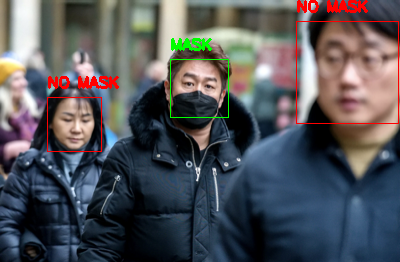

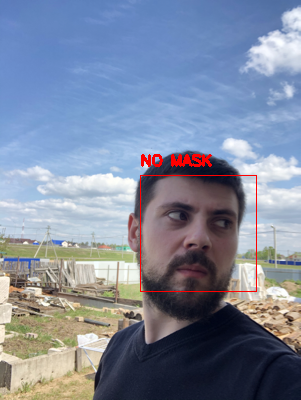

In [67]:
# show the marked_img_content
col_name="marked_img_content"
image_list = final_df.select(col_name).toPandas()[col_name]
render_image(image_list)

In [26]:
stream.stop()

In [ ]:
# stop sparksession
spark.sparkContext.stop()